# Comparison with Satellite Laser Ranging (SLR) TWSA

In this notebook, we compare our TWS reconstruction to a TWS product from IGG Bonn which combines gravity field measurements of SLR and DORIS.

In [68]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from cmcrameri import cm
import seaborn as sns
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR, repeat_by_weight


In [2]:
# Register dask progress bar
ProgressBar(minimum=5).register()


In [3]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/paper"


## Data Preprocessing

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [4]:
our_store = (
    ROOT_DIR / "models/predictions/ensemble-mixed/ensemble-mixed_era_best-mae.zarr"
)
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"
slr_store = ROOT_DIR / "data/processed/igg-slr-hybrid.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
slr = xr.open_zarr(slr_store)
recs = xr.open_zarr(recs_store)
our = xr.open_zarr(our_store).twsa.rename("twsa_our")


In [5]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, slr, recs, our])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


Specify variables of interest and their descriptive names:

In [6]:
vars_verbose = {
    "twsa_our": "DeepRec (Ours)",
    "twsa_gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "twsa_csr": "CSR (GRACE)",
}
eval_names = vars_verbose.keys()


In [7]:
grace_name = "twsa_csr"
our_name = "twsa_our"
slr_name = "twsa_slr_gauss"


Remove time steps not available in the evaluation product:

In [8]:
ds_slrtime = ds_all[[*eval_names, slr_name]].where(slr.time, drop=True).compute()

[########################################] | 100% Completed | 6.00 s


Calculate basin averages:

In [9]:
# Dims: ("model", "region")
ds_basin = (
    # Basins over 200,000 km²
    ds_slrtime.chunk(lat=-1, lon=-1, time=10)
    .dr.select_basins(top=72)
    .dr.weight_lat()
    .mean(["lat", "lon"])
).compute()
ds_basin


[########################################] | 100% Completed | 70.24 s


<xarray.Dataset> Size: 1MB
Dimensions:                (time: 332, region: 72)
Coordinates:
  * time                   (time) datetime64[ns] 3kB 1992-11-01 ... 2020-06-01
  * region                 (region) object 576B 'Amazon' 'Congo' ... 'Ural'
Data variables:
    twsa_our               (region, time) float64 191kB -138.5 -68.82 ... -53.09
    twsa_gap               (region, time) float64 191kB -138.3 -64.19 ... -54.38
    humphrey_gsfc_detrend  (region, time) float64 191kB -217.4 -128.4 ... nan
    li_csr_full            (region, time) float64 191kB -201.1 -128.5 ... -62.84
    yin_csr_full           (region, time) float64 191kB -133.0 -75.3 ... -43.17
    twsa_csr               (region, time) float64 191kB nan nan ... -56.81
    twsa_slr_gauss         (region, time) float64 191kB -192.3 -82.75 ... -31.0

Split into Pre-GRACE and GRACE periods:

In [10]:
ds_basin_pre = ds_basin.drop_vars(grace_name).sel(time=slice(None, "2001"))
ds_basin_post = ds_basin.sel(time=slice("2002", None))
# Drop time stamps which are not available for at least one variable
ds_basin_pre = ds_basin_pre.where(ds_basin_pre.dr.time_notnull("region"), drop=True)
ds_basin_post = ds_basin_post.where(ds_basin_post.dr.time_notnull("region"), drop=True)

### Basin scale PCC

In [11]:
# Calculate PCC for pre-GRACE era
da_pcc_pre = metrics.pearson_r(
    # Model are evaluated, SLR is the truth
    ds_basin_pre.drop_vars(slr_name),
    ds_basin_pre[slr_name],
    dim="time",
    skipna=True,
).to_dataarray("model")

# Calculate PCC for GRACE era
da_pcc_post = metrics.pearson_r(
    # Model are evaluated, SLR is the truth
    ds_basin_post.drop_vars(slr_name),
    ds_basin_post[slr_name],
    dim="time",
    skipna=True,
).to_dataarray("model")


In [49]:
# Combine along new `era` dimension
da_pcc = xr.concat([da_pcc_pre, da_pcc_post], dim=pd.Index(["pre", "post"], name="era"))


## Map plots

In [33]:
pcc_kwargs = dict(
    coastlines=True,
    gridlines=True,
    cmap="magma",
    vmin=0,
    vmax=1,
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True),
    add_colorbar=False,
    cbar_kwargs=None,
)
basinlines_kwargs = dict(
    edgecolor="black", linewidth=0.5, facecolor="None", rasterized=True, zorder=3.0
)

pcc_cbar_kwargs = dict(location="bottom", aspect=50, shrink=0.66, extend="min")


In [27]:
# Create a dummy array with the dimensions (lat x lon)
da_dummy = xr.zeros_like(ds_slrtime[our_name].isel(time=0, drop=True)).rename("dummy")

In [15]:
# Get start and end years of time series
times_pre = ds_basin_pre.get_index("time")
times_post = ds_basin_post.get_index("time")

period_pre = (times_pre[0].year, times_pre[-1].year)
period_post = (times_post[0].year, times_post[-1].year)

In [16]:
# GeoDataFrame containing basin shapes and areas
gdf_basin_shapes = basins(top=72)


In [17]:
# Select our reconstruction and GRACE
our_pcc_pre = da_pcc_pre.sel(model=our_name, drop=True)
our_pcc_post = da_pcc_post.sel(model=our_name, drop=True)
csr_pcc_post = da_pcc_post.sel(model=grace_name, drop=True)


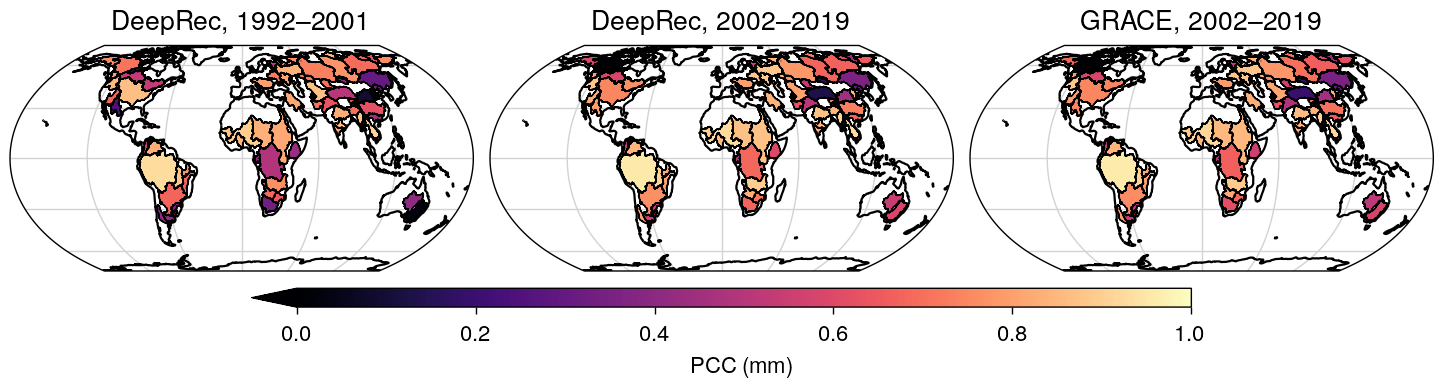

In [85]:
fig, axs = plt.subplots(
    ncols=3, figsize=(7.2, 2.1), subplot_kw={"projection": ccrs.EqualEarth()}
)

# PCC Ours Pre-GRACE
p_pcc = our_pcc_pre.dr.projplot_basins(da_dummy, ax=axs[0], **pcc_kwargs)
axs[0].set(title=f"DeepRec, {period_pre[0]}--{period_pre[1]}")

# PCC Ours GRACE era
our_pcc_post.dr.projplot_basins(da_dummy, ax=axs[1], **pcc_kwargs)
axs[1].set(title=f"DeepRec, {period_post[0]}--{period_post[1]}")

# PCC GRACE
csr_pcc_post.dr.projplot_basins(da_dummy, ax=axs[2], **pcc_kwargs)
axs[2].set(title=f"GRACE, {period_post[0]}--{period_post[1]}")

for ax in axs:
    # Add basinlines
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

# Add colorbars
fig.colorbar(p_pcc, ax=axs, label="PCC (mm)", **pcc_cbar_kwargs)


## Boxplots

In [ ]:
# Convert DataArray to DataFrame
df_pcc = da_pcc.to_dataframe(name="pcc").reset_index()
df_pcc.model = df_pcc.model.replace(vars_verbose)
df_pcc

,era,model,region,pcc
0,pre,Humphrey's GSFC Rec,Amazon,0.930936
1,pre,Humphrey's GSFC Rec,Congo,0.496536
2,pre,Humphrey's GSFC Rec,Nile,0.824488
3,pre,Humphrey's GSFC Rec,Mississippi,0.840801
4,pre,Humphrey's GSFC Rec,Ob,0.769961
...,...,...,...,...
859,post,Yin's CSR Rec,Har,0.288730
860,post,Yin's CSR Rec,Liao,0.331695
861,post,Yin's CSR Rec,Olenek,0.746813
862,post,Yin's CSR Rec,Ogooue,0.468350


Weight according to basin size. We achieve this by repeating samples (rows) by an integer number proportional to their basin size.

In [43]:
# Series of basin areas
s_basin_areas = gdf_basin_shapes.rename(
    columns={"riverbasin": "region", "sum_sub_ar": "area"}
).set_index("region")["area"]
s_basin_areas

region
Amazon         5965893.5
Congo          3705225.4
Nile           3353204.0
Mississippi    3240620.1
Ob             3040604.1
                 ...    
Har             229005.7
Liao            220125.2
Olenek          217723.1
Ogooue          215213.0
Ural            211009.2
Name: area, Length: 72, dtype: float64

In [48]:
# Convert area to integer (we define the smallest area as 10)
s_basin_ints = (s_basin_areas / s_basin_areas.min() * 10).round().astype(int)
s_basin_ints


region
Amazon         283
Congo          176
Nile           159
Mississippi    154
Ob             144
              ... 
Har             11
Liao            10
Olenek          10
Ogooue          10
Ural            10
Name: area, Length: 72, dtype: int32

In [55]:
s_basin_ints


region
Amazon         283
Congo          176
Nile           159
Mississippi    154
Ob             144
              ... 
Har             11
Liao            10
Olenek          10
Ogooue          10
Ural            10
Name: area, Length: 72, dtype: int32

In [65]:
# Merge with area integers
df_pcc_area = df_pcc.merge(s_basin_ints, left_on="region", right_index=True)
df_pcc_area

,era,model,region,pcc,area
0,pre,Humphrey's GSFC Rec,Amazon,0.930936,283
1,pre,Humphrey's GSFC Rec,Congo,0.496536,176
2,pre,Humphrey's GSFC Rec,Nile,0.824488,159
3,pre,Humphrey's GSFC Rec,Mississippi,0.840801,154
4,pre,Humphrey's GSFC Rec,Ob,0.769961,144
...,...,...,...,...,...
859,post,Yin's CSR Rec,Har,0.288730,11
860,post,Yin's CSR Rec,Liao,0.331695,10
861,post,Yin's CSR Rec,Olenek,0.746813,10
862,post,Yin's CSR Rec,Ogooue,0.468350,10


In [66]:
# Create weighted dataframe (columns repeated according to area integers)
df_pcc_weighted = repeat_by_weight(df_pcc_area, "area")


In [111]:
# Order by increasing mean
my_order = (
    df_pcc[df_pcc.era == "pre"]
    .groupby(by=["model"])["pcc"]
    .mean()
    # Sort GRACE to the beginning
    .sort_values(na_position="first")
    .index
)
my_order


Index(['CSR (GRACE)', 'WGHM', 'Humphrey's GSFC Rec', 'DeepRec (Ours)',
       'Yin's CSR Rec', 'Li's CSR Rec'],
      dtype='object', name='model')

In [86]:
# For creating self-explaining text on figure legends
legend_renamer = {
    "era": "Era",
    "pre": f"Pre-GRACE ({period_pre[0]}--{period_pre[1]})",
    "post": f"GRACE ({period_post[0]}--{period_post[1]})",
    "area": r"Area ($10^6$ km$^2$)",
}


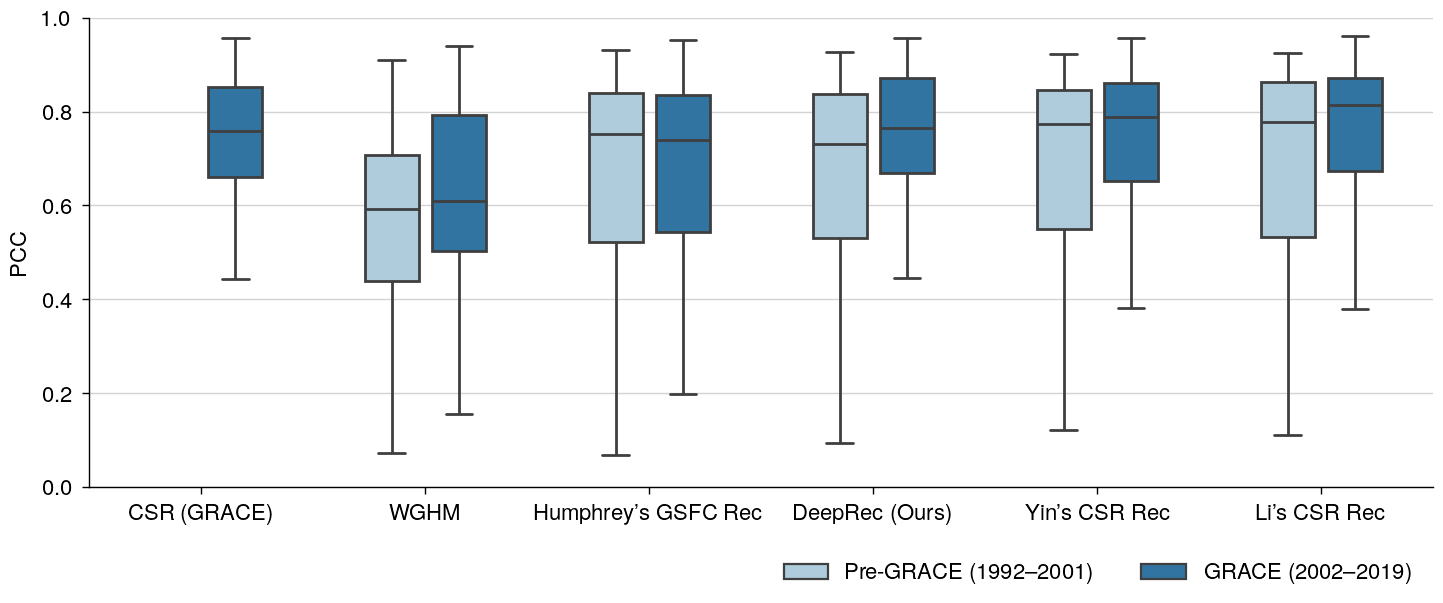

In [112]:
fig, ax = plt.subplots(figsize=(7.2, 3))
sns.boxplot(
    df_pcc_weighted,
    y="pcc",
    x="model",
    hue="era",
    width=0.6,
    gap=0.2,
    ax=ax,
    order=my_order,
    showfliers=False,
    palette="Paired",
)
ax.set(ylabel="PCC", xlabel=None, ylim=(0, 1))
ax.yaxis.grid()
ax.legend(title=None, ncols=2, loc="lower right", bbox_to_anchor=(1, -0.25))
# Replace legend texts
for text in ax.legend_.texts:
    t = text.get_text()
    if t in legend_renamer:
        t = legend_renamer[t]
    text.set_text(t)


## Combine everything

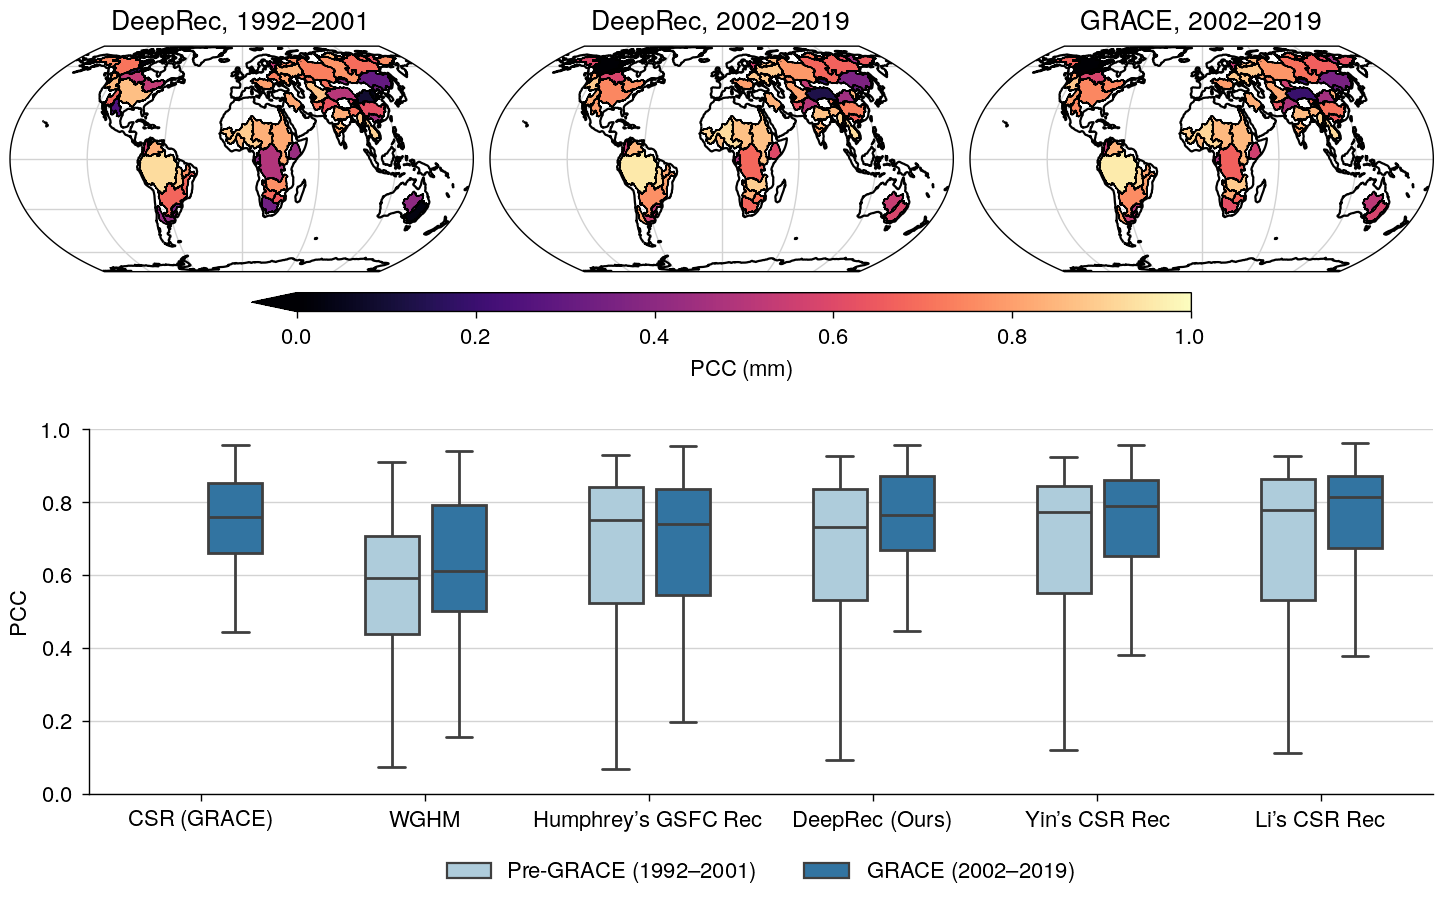

In [114]:
fig = plt.figure(figsize=(7.2, 5))
subfigs = fig.subfigures(nrows=2, hspace=0.05)

axs_geo = subfigs[0].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})
ax_box = subfigs[1].subplots(1, 1)

### MAP PLOTS ###

# PCC Ours Pre-GRACE
p_pcc = our_pcc_pre.dr.projplot_basins(da_dummy, ax=axs_geo[0], **pcc_kwargs)
axs_geo[0].set(title=f"DeepRec, {period_pre[0]}--{period_pre[1]}")

# PCC Ours GRACE era
our_pcc_post.dr.projplot_basins(da_dummy, ax=axs_geo[1], **pcc_kwargs)
axs_geo[1].set(title=f"DeepRec, {period_post[0]}--{period_post[1]}")

# PCC GRACE
csr_pcc_post.dr.projplot_basins(da_dummy, ax=axs_geo[2], **pcc_kwargs)
axs_geo[2].set(title=f"GRACE, {period_post[0]}--{period_post[1]}")

for ax in axs_geo:
    # Add basinlines
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

# Add colorbars
subfigs[0].colorbar(p_pcc, ax=axs_geo, label="PCC (mm)", **pcc_cbar_kwargs)


### BOXPLOT ###

sns.boxplot(
    df_pcc_weighted,
    y="pcc",
    x="model",
    hue="era",
    width=0.6,
    gap=0.2,
    ax=ax_box,
    order=my_order,
    showfliers=False,
    palette="Paired",
)

ax_box.set(ylabel="PCC", xlabel=None, ylim=(0, 1))
ax_box.yaxis.grid()
ax_box.legend(title=None, ncols=2, loc="lower center", bbox_to_anchor=(0.5, -0.3))

# Replace legend texts
for text in ax_box.legend_.texts:
    t = text.get_text()
    if t in legend_renamer:
        t = legend_renamer[t]
    text.set_text(t)

fig.savefig(FIGURE_DIR / "slr_pcc.pdf", backend="pgf")